In [1]:
import hklearn 
from hklearn import Stack
import joblib
import matplotlib.pyplot as plt
import numpy as np
from hklearn.transforms import LogRatioScaler
import hylite
import pandas as pd
from hycore import loadShed
from sklearn.metrics import r2_score
import os
from matplotlib.colorbar import Colorbar
from matplotlib.transforms import Bbox

In [2]:
#setup figure styles
import matplotlib as mpl
plt.style.use(['default'])
mpl.rcParams['font.size'] = 20
mpl.rcParams['figure.titleweight'] = 'normal'
mpl.rcParams['savefig.dpi'] = 350
mpl.rcParams['axes.spines.bottom'] = True
mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = True
mpl.rcParams['axes.spines.top'] = True
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 2
dipcmap = plt.get_cmap("RdYlGn_r")

In [3]:
# load data
df = pd.read_excel('SWIR_MWIR_LWIR_SpecLib_v3.xlsx')
shed = loadShed('VolcanoSamples.shed')
sample_id = np.array(df['ID']) # ID of each sample
volcanoes = np.array(df['volcano']) # ID of each sample

In [4]:
# get target variables
target_names = ['density','porosity','UCS2_MPa','E_GPa']
y = np.array(df[target_names])

# put this in a HyLibrary instance too for consistency
y = hylite.HyLibrary(y,lab=list(df['ID']), wav=[0,1,2,3] )
y.set_band_names(target_names)

In [5]:
# get spectra
wav = np.array( df.columns[15:] ).astype(float)
ids = np.array(df['ID'])
lib = hylite.HyLibrary( data = np.array( df.iloc[:,15:] ), 
                        lab=ids, 
                        wav=wav )

In [6]:
# split into each sensors
libs = {}
dims = []
b = shed.getBoxes()[0]
for s in ['FENIX','FX50','LWIR']:
    libs[s] = lib.export_bands((b.get(s).get_wavelengths()[0], b.get(s).get_wavelengths()[-1]))
    dims.append(libs[s].band_count())
b.free()

In [7]:
# build stack (this automatically removes nans and other important stuff!)
S = hklearn.Stack(list(libs.keys()), data=list(libs.values()), y=y, target_names=target_names )

# do some spectral preprocessing
S = S.smooth(window=5, order=1).resample({'FENIX':hklearn.VSWIR, 'FX50':hklearn.MWIR, 'LWIR':hklearn.LWIR})
S = S.hc(hull={'FENIX' : 'upper', 'FX50' : 'upper', 'LWIR' : 'lower' },vb=False).inv()

In [8]:
# fit a set of PCAs that reduce the dimensionality of the input spectra for some estimators (when xtransform = True )
S.pca(concat=True, n_components=0.99, normalise=True) 

### Transform target variables

To ensure physically meaningful predictions from our regression models, we do a log-transform on our physical property measurements (they cannot be negative and cannot be 0) and use a robust scaler to scale them to approximately the same range. For porosity, we apply the log-transform to porosity / (1-porosity) (i.e. the ratio of pores to non-pores ) to further ensure that it never exceeds 1.

In [9]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import RobustScaler
def fwd( f ):
    f = f.copy()
    # express porosity as a ratio to ensure scaling between 0 and 1
    f[...,1] /= (1-f[:,1]) # (note that we take a log in the transformer below)
    return f
def inv( f ):
    f = f.copy()
    f[...,1] /= (1+f[:,1])
    return f
def fwd2( f ):
    return f**(1/2)
def inv2(f):
    return f**2

# transform data with a log followed by a power transform
# this ensures (1) that no negative outputs are possible, and (2) the
# input data for the models is roughly normal :-) 
LT = make_pipeline( FunctionTransformer( fwd, inv ), FunctionTransformer( fwd2, inv2 ), 
                    RobustScaler(quantile_range=(2,98)) )
                    #PowerTransformer( method='yeo-johnson', standardize=True ) )
LT.fit( S.y() )
S.add_transform('y', LT )

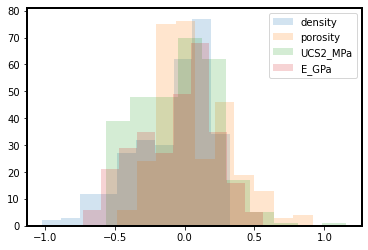

In [10]:
for f in S.target_names:
    plt.hist( S.y(f, transform=True).squeeze(), alpha=0.2, label=f )
plt.legend()
plt.show()

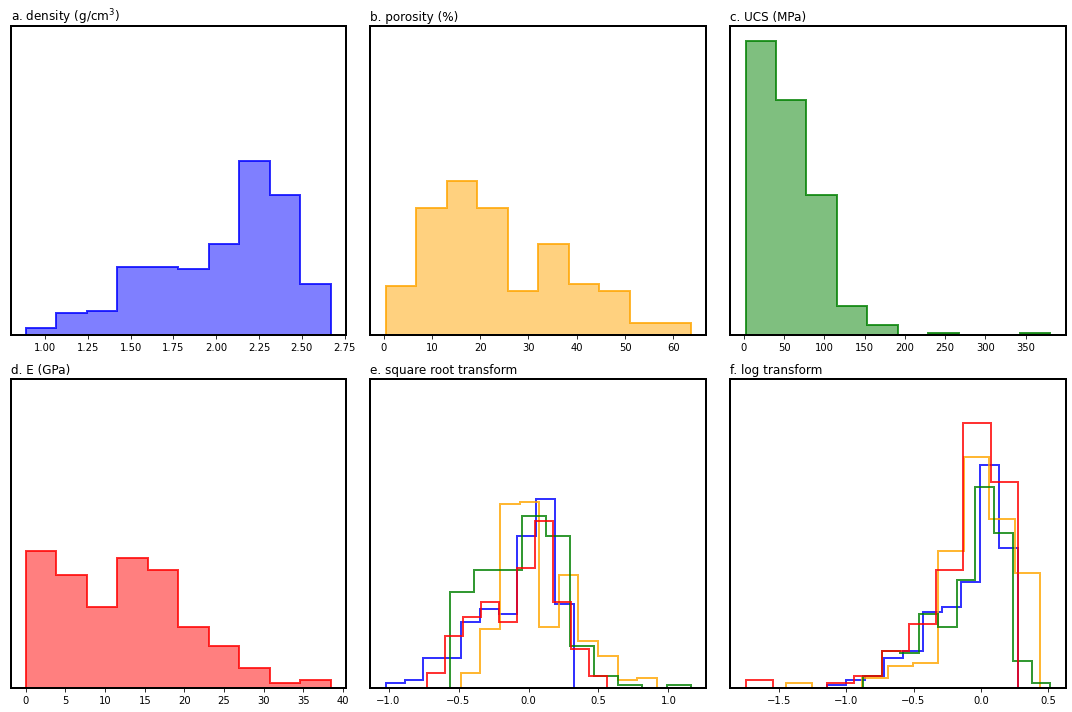

In [11]:
# build a nice figure
fig,ax = plt.subplots(2,3,figsize=(15,10), sharey=True)
ax=ax.ravel()
colors = ['blue','orange','green', 'red']
labels = ['density (g/cm$^3$)','porosity (%)','UCS (MPa)','E (GPa)']
for i in range(4):
    if i == 1: # convert porosity to a percentage
        ax[i].hist(S.y(transform=False)[:,i]*100, color=colors[i], alpha=0.5)
        ax[i].hist(S.y(transform=False)[:, i]*100, histtype='step', linewidth=2, color=colors[i], alpha=0.8)
    else:
        ax[i].hist(S.y(transform=False)[:,i], color=colors[i], alpha=0.5)
        ax[i].hist(S.y(transform=False)[:, i], histtype='step', linewidth=2, color=colors[i], alpha=0.8)
    #ax[-1].hist( S.y(transform=True)[:,i], alpha=0.2, label=labels[i] )
    ax[-2].hist(S.y(transform=True)[:, i], histtype='step', label=labels[i], linewidth=2, color=colors[i], alpha=0.8)
    
    # also plot log transformed data for reference
    lt = np.log(S.y(transform=False)[:, i])
    lt -= np.median(lt, axis=0) # median = 0
    lt /= (np.percentile(lt, 98,axis=0) - np.percentile(lt, 2,axis=0))  # 2 - 98 percentile range = 1
    ax[-1].hist(lt, histtype='step', label=labels[i], linewidth=2, color=colors[i], alpha=0.8)
    ax[i].set_title('%s. %s'%('abcd'[i], labels[i]), loc='left' )
    ax[i].set_yticks([])
ax[-2].set_title("e. square root transform", loc='left')
ax[-2].set_yticks([])
ax[-1].set_title("f. log transform", loc='left')
ax[-1].set_yticks([])

fig.tight_layout()

fig.savefig("./figures/distributions.png", dpi=300)
fig.savefig("./figures/distributions.svg", dpi=300)
fig.show()


### Define folds

We will use a k-fold cross validation to assess our model accuracy. But we want folds that match the orignal data distribution, so we create and specify them here.

In [12]:
# define some groups based on porosity (as a useful proxy for the data distribution)
np.random.seed(42)
p = 'porosity'
counts, bins = S.group_with_binning(p, nbins=4, transform=True)
print("%d bins defined using %s. Smallest group has %d samples"%((len(counts), p, np.min(counts))))

# first set a test / train split
# N.B. we only use this for testing / development (as models only need to be trained once)
# K-fold cross validation (see the following cell) is then applied to estimate accuracy
S.set_test_set( S.stratified_sample( 0.3 ) ) # set test set to a 30% stratified split.

# define classes using porosity to ensure nice folding
S.set_folds(k=5, use_groups=True) # define 5 folds using stratified k-fold split

4 bins defined using porosity. Smallest group has 12 samples


Save stack for easy access

In [15]:
S.save('volcanoes.stack')

### Also define a dictionary of our spectral features and save this (for plotting nice figures)

In [22]:
from hylite.analyse import band_ratio, minimum_wavelength

# get spectral indices
indices = {}

#indices['Qtz'] = np.clip( band_ratio(lwir, [8216., 9200.], [8620., 8620.]).X()[:,0], 0.8, np.inf )
indices['Qtz'] = np.clip( band_ratio(lib, 9240., 9600.).X()[:,0], 0.8, np.inf )
#indices['Qtz2'] = minimum_wavelength( mwir, 4600., 4800., method='gauss', minima=True, trend='hull', vb=False )[0].data[:,0,0]
indices['Qtz2'] = minimum_wavelength( lib, 4400., 4600., method='gauss', minima=True, trend='hull', vb=False )[0].data[:,0,0]

indices['H2O'] = minimum_wavelength( lib, 1800., 2120., method='gauss', minima=True, trend='hull', vb=False )[0].data[:,0,0]
indices['OH'] = minimum_wavelength( lib, 1350., 1600., method='gauss', minima=True, trend='hull', vb=False )[0].data[:,0,0]
indices['SO4'] = minimum_wavelength( lib, 1700., 1800., method='gauss', minima=True, trend='hull', vb=False )[0].data[:,0,0]
indices['AlOH'] = minimum_wavelength( lib, 2150., 2240., method='gauss', minima=True, trend='hull', vb=False )[0].data[:,0,0]
indices['FeOH'] = minimum_wavelength( lib, 2230., 2280., method='gauss', minima=True, trend='hull', vb=False )[0].data[:,0,0]
indices['MgOH'] = minimum_wavelength( lib, 2280., 2330., method='gauss', minima=True, trend='hull', vb=False )[0].data[:,0,0]
indices['Kaol'] = minimum_wavelength( lib, 2100., 2200., method='gauss', minima=True, trend='hull', vb=False )[0].data[:,0,0]
#indices['Qtz'] = minimum_wavelength( lwir, 7640., 8630., method='gauss', minima=False, trend='hull', vb=False )[0].data[:,0,0]
indices['fmi'] = minimum_wavelength( lib, 7640., 10620., method='poly', minima=False, trend='hull', vb=False )[0].data[:,0,1] # N.B FMI is the position
indices['fmi'] = 1 - ( (indices['fmi'] - 7640) / (10620-7640)) # convert to range between 0 [mafic] and 1 [felsic]

indices['hydration'] = 0.5*(indices['H2O'] + indices['OH']) # average the OH- and H-O-H components to get hydration index

# also store additional useful info for plotting
indices['sample_id'] = sample_id
indices['volcanoes'] = volcanoes

In [23]:
import dill
with open('indices.dill','wb') as f:
    dill.dump( indices, f )